In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import csv
%matplotlib inline

## Prepare labelling data

Heatmaps, masks + coords

In [2]:
ordered_verts = ['T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'L1', 'L2', 'L3', 'L4']

In [3]:
sag_path = '/home/donal/PhD/initial_spines/CT_models/data/all_verts/'

In [4]:
data_list_dir = '/home/donal/PhD/initial_spines/CT_models/data_lists/'
data_lists = []
for file in os.listdir(data_list_dir):
    if '_q' in file:
        print(file)
        data_lists.append(data_list_dir + file)
print(data_lists)

data_list_q2.txt
data_list_q4.txt
data_list_q1.txt
data_list_q3.txt
['/home/donal/PhD/initial_spines/CT_models/data_lists/data_list_q2.txt', '/home/donal/PhD/initial_spines/CT_models/data_lists/data_list_q4.txt', '/home/donal/PhD/initial_spines/CT_models/data_lists/data_list_q1.txt', '/home/donal/PhD/initial_spines/CT_models/data_lists/data_list_q3.txt']


In [5]:
def get_mask(pts_file):
    #Get vert. body annotations
    with open(pts_file, 'r') as f:
        text = f.readlines()
        lines = [line.strip() for line in text]
        start = lines.index('{')
        end = lines.index('}')
        x = [float(x.split(' ')[0]) for x in lines[start+1:end]]
        y = [float(x.split(' ')[1]) for x in lines[start+1:end]]
        points = (x, y)
    return points

def get_id(data_list):
    """
    Collect paths to point files, in a dict
    """
    sag_files = [file for file in os.listdir(sag_path)]
    pts_files = {}
    with open(data_list, 'r') as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines]
        for line in lines:
            pts, img = line.split(':')
            id_ = pts.split('.')[0]
            vert_list = list(filter(lambda x: f'{id_}' in x, sag_files))
            volume_name = id_.split('_midline')[0] + '.nii'
            pts_files[volume_name] = vert_list
    return pts_files

def get_points(pts_files, level=None):
    """
     Get + organise annotations
    """
    mask_dict = {} #All landmark annotations for making a mask of vert.
    for key, val in pts_files.items():
        name = f"{key.split('.')[0]}"
        mask_dict[name] = {}
        for elem in val:
            # Iterate over available vert. annotations
            # Find name of vertebra
            name_split = re.findall('[0-9a-zA-Z][^A-Z]*',
                                    os.path.splitext(elem)[0])
            vert = name_split[-1].split('_')[0]
            if level is not None and vert != level: continue
            # Get all landmark point annotations
            points = get_mask(os.path.join(sag_path, elem))
            mask_dict[name][vert] = points
        if level is not None and level not in mask_dict[name]:
            del mask_dict[name]
    return mask_dict

In [6]:
fold_data = {}
for data_list in data_lists:
    print(data_list)
    num = data_list.split('/')[-1].split('.')[0].split('_')[-1]
    pts_files = get_id(data_list)
    print('FOLD:', num)
    print(f'Found {len(list(pts_files.keys()))} points files')
    mask_dict = get_points(pts_files, level=None)
    print(f'Found {len(list(mask_dict.keys()))} patients w. full vert. annotations.')
    fold_data[num] = mask_dict

/home/donal/PhD/initial_spines/CT_models/data_lists/data_list_q2.txt
FOLD: q2
Found 87 points files
Found 87 patients w. full vert. annotations.
/home/donal/PhD/initial_spines/CT_models/data_lists/data_list_q4.txt
FOLD: q4
Found 102 points files
Found 102 patients w. full vert. annotations.
/home/donal/PhD/initial_spines/CT_models/data_lists/data_list_q1.txt
FOLD: q1
Found 100 points files
Found 100 patients w. full vert. annotations.
/home/donal/PhD/initial_spines/CT_models/data_lists/data_list_q3.txt
FOLD: q3
Found 86 points files
Found 86 patients w. full vert. annotations.


### Masks + input image

In [7]:
from PIL import Image, ImageDraw
from scipy.spatial import ConvexHull, Delaunay
import SimpleITK as sitk

In [8]:
def points2frame(name, points_dict):
    # Convert points into correct coordinate system (Scaling + padding)
    vol = sitk.ReadImage(f'/data/PAB_data/ct_volumes/{name}.nii')
    out_dict = {}
    for vert, points in points_dict.items():
        scale = vol.GetSpacing()[0]/1.25
        padding =(512-vol.GetSize()[0]*scale)//2
        x, y = points
        x = [t * scale + padding for t in x]
        y = [t* scale + padding for t in y]
        out_dict[vert] = (x, y)
    return out_dict

def points2mask(points_dict):
    # Convert points to mask by convexhull
    mask_holder = mask_holder = np.zeros((512, 512, len(ordered_verts)+1), dtype=np.int16)
    for vert, points in points_dict.items():
        channel = ordered_verts.index(vert)
        x, y = points
        form_points = np.column_stack((x, y))
        hull = ConvexHull(form_points)
        indices = hull.vertices
        hull_points = [(x, y) for x, y in form_points[indices, :]]
        img = Image.new('I', (512, 512), 0)
        ImageDraw.Draw(img).polygon(hull_points, outline=1, fill=1)
        mask = np.array(img)
        mask_holder[..., channel + 1] = np.flip(mask, axis=1)
    return np.argmax(mask_holder, axis=-1)

q2
q4
q1
q3


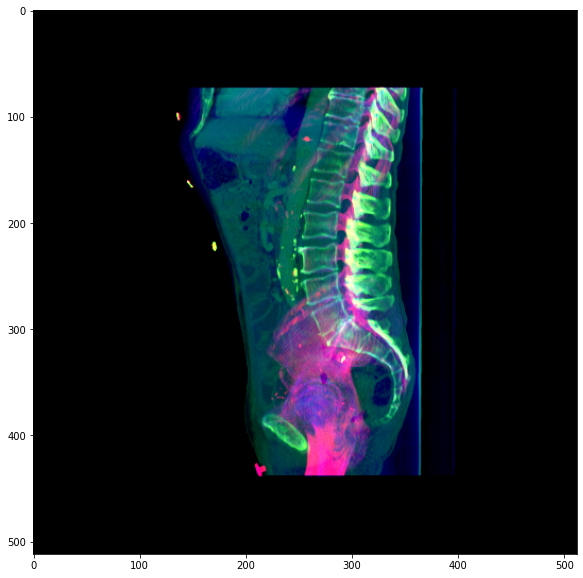

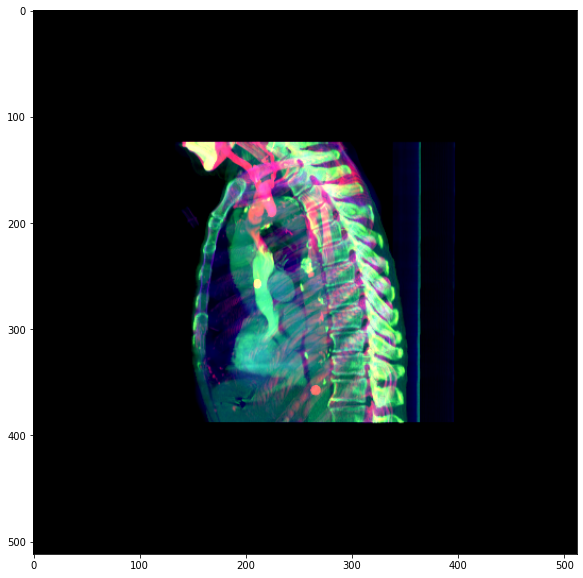

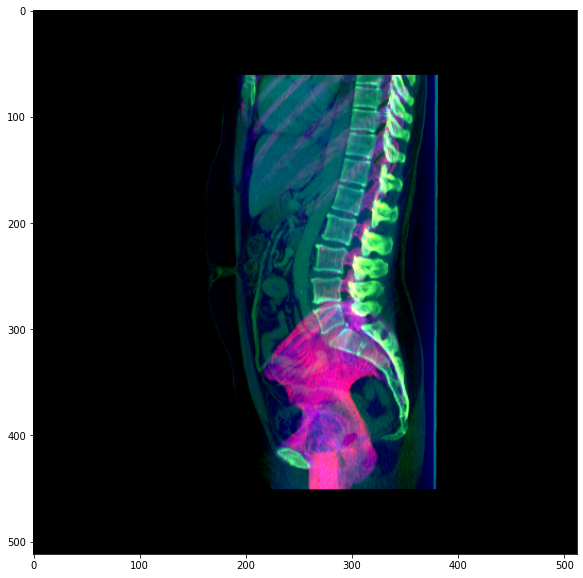

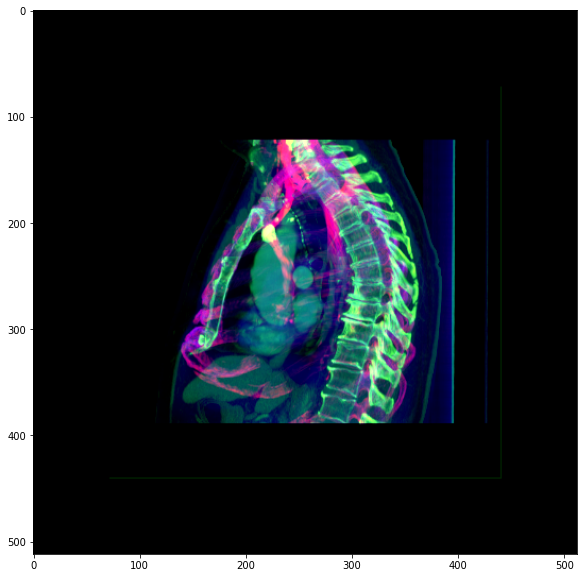

In [9]:
for fold, mask_dict in fold_data.items():
    print(fold)
    for name, points_dict in mask_dict.items():
        midline = np.load(f'/data/PAB_data/images_sagittal/sagittal_midline/{fold}/{name}.npy').astype(np.float32)
        midline /=255
        img = np.load(f'../images_sagittal/all_projections/{name}.npy').astype(np.float32)
        cat_img = np.stack([img[..., 0], midline, img[..., 2]], axis=-1)
        points = points2frame(name, points_dict)
        mask = points2mask(points)
#         os.makedirs(f'/data/PAB_data/vert_labelling/{fold}/targets/masks/', exist_ok=True)
#         os.makedirs(f'/data/PAB_data/vert_labelling/{fold}/slices/', exist_ok=True)
#         np.save(f'/data/PAB_data/vert_labelling/{fold}/targets/masks/{name}.npy', mask)
#         np.save(f'/data/PAB_data/vert_labelling/{fold}/slices/{name}.npy', cat_img)
        plt.figure(figsize=(10,10))
        #plt.imshow(midline, cmap='gray')
        plt.imshow(cat_img)
        #plt.imshow(mask, alpha=0.5)  
        break
    #break

## Heatmaps + coords

In [10]:
import scipy.stats as stats
import scipy.ndimage as snd
from scipy.ndimage import gaussian_filter
import torch.nn.functional as F
from operator import mul
from functools import reduce

In [11]:
def point2heatmap(points):
    heatmap_holder = np.zeros((512, 512, len(ordered_verts)+1), dtype=np.float32)
    for vert, point in points.items():
        channel = ordered_verts.index(vert) + 1
        x, y = point
        xd = np.linspace(0, 512, 512)
        #gauss = np.array(stats.norm.pdf(xd, y, 10))[..., np.newaxis]
        #tmp = np.tile(gauss, (1, 512)).astype(np.float32)/512
        #gauss = stats.multivariate_normal.pdf(m)
        tmp = np.zeros((512, 512))
        tmp[round(y), round(x)] = 1
        tmp = gaussian_filter(tmp, sigma=5)
        heatmap_holder[..., channel] = tmp
    return heatmap_holder

def get_coords(heatmap):
    #norm_map = dsntnn.flat_softmax(heatmap)
    return dsntnn.dsnt(heatmap, normalized_coordinates=False)


In [12]:
import dsntnn
import torch

In [14]:
for fold, mask_dict in fold_data.items():
    print(fold)
    for name, points_dict in mask_dict.items():
        midline = np.load(f'/data/PAB_data/images_sagittal/sagittal_midline/{fold}/{name}.npy').astype(np.float32)
        midline /= 255
        
        points = points2frame(name, points_dict)
        centre_points = {}
        for level, pts in points.items():
            centre_points[level] = (512- np.mean(pts[0]), np.mean(pts[1]))
        
        heatmap = np.moveaxis(point2heatmap(centre_points), -1, 0)[np.newaxis]
        #heatmap = dsntnn.flat_softmax(torch.tensor(heatmap)).numpy()
        
        dsnt_coords = get_coords(torch.tensor(heatmap)).numpy()
        os.makedirs(f'/data/PAB_data/vert_labelling/{fold}/targets/heatmaps/', exist_ok=True)
        os.makedirs(f'/data/PAB_data/vert_labelling/{fold}/targets/coordinates/', exist_ok=True)
        np.save(f'/data/PAB_data/vert_labelling/{fold}/targets/heatmaps/{name}.npy', np.squeeze(heatmap))
        
        
#         with open(f'/data/PAB_data/vert_labelling/{fold}/targets/coordinates/{name}.csv', 'w') as f:
#             wrt = csv.writer(f, dialect='excel')
#             wrt.writerow(['Level', 'X', 'Y'])
#             for vert in ordered_verts:
#                 if vert not in centre_points: continue
#                 x, y = centre_points[vert]
#                 wrt.writerow([vert, x, y])
    
#         cmap = sns.cubehelix_palette(start=1.5, rot=-1.5, gamma=0.8, as_cmap=True)
#         fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#         ax.imshow(midline, cmap='gray')
#         #ax.imshow(np.argmax(heatmap, axis=1)[0], alpha=0.5)
#         ax.imshow(np.max(heatmap, axis=1)[0], alpha=0.5, cmap=cmap)
        
# #         for vert, point in centre_points.items():
# #             ax.scatter(*point, s=20, c='y', marker='*')
# #             ax.text(*point, vert, c='r', size=15)
    
#         for channel in range(dsnt_coords.shape[1]):
#             x, y = dsnt_coords[0, channel]
#             ax.scatter(x, y, s=20, c='r', marker='+')
#             if channel == 0: continue
#             vert = ordered_verts[channel - 1]
#             ax.text(x, y, vert, c='y', size=15)
#         break
#     break

q2
q4
q1
q3
